Putting together the 2 steps written so far. 
- #### 1. Motion - Convolution
Example: For every movement the robot makes, if we have 3 different outcomes, the probability for a certain outcome is sum of probabilities of _y_ times the probability of _x given y_
![title](img_01_convolution.jpg)


**$$P(X) = {\large \Sigma_y \:}   { P(X\mid y_i) . P(y_i)} $$**
- #### 2. Measurement - Multiplication
 $$P(X\mid Z) = { {\alpha \:} . P(Z\mid X) . P(X)} $$   $$ where  \: p(X)  \: is \: the \: prior \: distribution \: and \: p(X | z), \: the \: posterior \: distribution$$
 
 These 2 steps are computed iteratively. The robot moves, its uncertainty increases, the robot measures and its uncertainty decreases.
 
 More concretely, the equations are written as
$$  \mathbf {\overline{bel} (X_t) = {\large \Sigma_{X \small {t-1}} \:} = P(X_t \mid X_{t \small -1}, u_t) \: . \: bel(X_{t \small -1})} $$
$$ \: \; where \: u \: is \: the \: control \: input $$

$$ \mathbf {bel(X_t) = \alpha \: . P(Z_t \mid X_t) \: . \overline{bel} (X_t)} $$

This is called **Bayes' Filter.**

In [1]:
from pylab import plot, show, ylim, legend
from distribution import *
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
def move(distribution, delta):
    
    return Distribution(distribution.offset + delta, distribution.values)

In [3]:
def convolve(a, b):
    
    len_a = len(a.values)
    len_tot = len_a + len(b.values) - 1 # Total length
    values = [0] * len_tot
    
    a_offset = a.start()
    b_offset = b.start()
    offset = b_offset + a_offset
    
    for i in xrange(0, len_tot):
        for j in xrange(i, -1, -1):
            values[i] += a.value(i - j +a.start()) * b.value(j + b.start())
    d = Distribution(offset, values)
    d.normalize()

    
    return d

In [4]:
def multiply(a, b):
    
    offset = max(a.start(), b.start())
    final_index = min(a.stop() - 1, b.stop() - 1)
    if offset > final_index: # There is no overlapping between the distributions
        offset = 0
        values = [0]
        d = Distribution(offset, values)
        return d
    else: # There is overlapping between the distributions
        values = [0] * (final_index - offset  + 1)
        for i in xrange(offset, final_index+1):
            values[i - offset] = a.value(i) * b.value(i)
        d = Distribution(offset, values)
        d.normalize()
        return d
    
    values = [0] * (final_index - offset +1)
    return a 

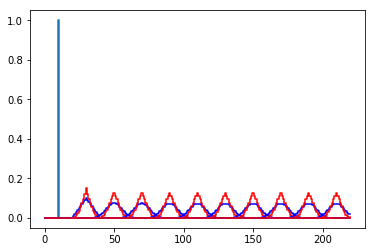

In [5]:
if __name__ == '__main__':
    arena = (0,220)

    # Start position. Exactly known - a unit pulse.
    start_position = 10
    position = Distribution.unit_pulse(start_position)
    plot(position.plotlists(*arena)[0], position.plotlists(*arena)[1],
         linestyle='steps')

    # Movement data.
    controls  =    [ 20 ] * 10

    # Measurement data. Assume (for now) that the measurement data
    # is correct. - This code just builds a cumulative list of the controls,
    # plus the start position.
    p = start_position
    measurements = []
    for c in controls:
        p += c
        measurements.append(p)

    # This is the filter loop.
    for i in xrange(len(controls)):
        # Move, by convolution. Also termed "prediction".
        control = Distribution.triangle(controls[i], 10)
        position = convolve(position, control)
        plot(position.plotlists(*arena)[0], position.plotlists(*arena)[1],
             color='b', linestyle='steps')

        #Measure, by multiplication. Also termed "correction".
        measurement = Distribution.triangle(measurements[i], 10)
        position = multiply(position, measurement)
        plot(position.plotlists(*arena)[0], position.plotlists(*arena)[1],
             color='r', linestyle='steps')
    
    show()

When the measurement accuracy of the robot is lesser than the control accuracy, the estimation accuracy is reduced. Note the plots below.
![title](img_02_different_widths.png)